In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import MNIST
import torchvision.transforms as transforms


class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        # mnist의 경우 28*28의 흑백이미지(input channel=1)이다.
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 5, padding=2)
        # feature map의 크기는 14*14가 된다
        # 첫번재 convolution layer에서 나온 output channel이 32이므로 2번째 input도 32
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 5, padding=2)
        # feature map의 크기는 7*7이 된다
        # fc -> fully connected, fc는 모든 weight를 고려해서 만들기 때문에 cnn에서는 locally connected를 이용하여 만든다.
        # nn.Linear에서는 conv를 거친 feature map을 1차원으로 전부 바꿔서 input을 한다. 이게 64*7*7
        self.fc1 = nn.Linear(64*7*7, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 64*7*7) # linear에 들어갈 수 있도록 reshape
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)


def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    avg_loss = 0
    # in training loop:
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # zero the gradient buffers
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step() # Does the update
        avg_loss+=F.nll_loss(output, target, reduction='sum').item()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    avg_loss/=len(train_loader.dataset)
    return avg_loss

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss,accuracy                                         

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

train_batch_size=64
test_batch_size=1000
epochs =30
lr=0.01
momentum = 0.5
seed = 1
log_interval = 1000
save_model = True

model = MnistModel().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# mean=0.5 std=1.0으로 Normalize한다
mnist_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (1.0,))
])

download_path = './MNIST_DATASET'
train_dataset = MNIST(download_path, transform=mnist_transform, train=True, download=True)
test_dataset = MNIST(download_path, transform=mnist_transform, train=False, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=train_batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=test_batch_size,
                                          shuffle=False)

train_losses = []
test_losses = []
accuracy_list = []
for epoch in range(1, epochs + 1):
    trn_loss = train(model, device, train_loader, optimizer, epoch,log_interval)
    test_loss,accuracy = test(model, device, test_loader)
    train_losses.append(trn_loss)
    test_losses.append(test_loss)
    accuracy_list.append(accuracy)


/home/pksll325/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302584

Test set: Average loss: 0.1592, Accuracy: 9506/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.292109

Test set: Average loss: 0.0866, Accuracy: 9718/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.050518

Test set: Average loss: 0.0642, Accuracy: 9790/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.033584

Test set: Average loss: 0.0543, Accuracy: 9812/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.092707

Test set: Average loss: 0.0456, Accuracy: 9849/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.009493

Test set: Average loss: 0.0395, Accuracy: 9862/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.069164

Test set: Average loss: 0.0378, Accuracy: 9870/10000 (99%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.030809

Test set: Average loss: 0.0362, Accuracy: 9874/10000 (99%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.007844

Test set: Average loss: 0.0322, Accuracy: 9892/10000 (99%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.028758


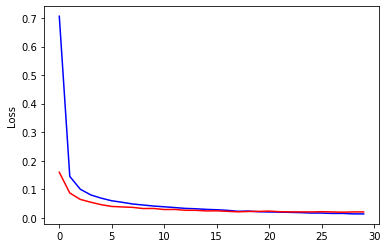

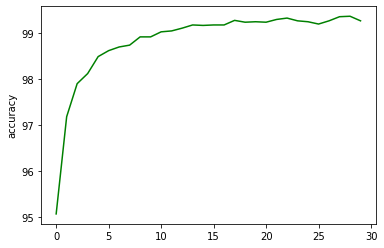

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_losses,'b')
plt.plot(test_losses,'r')
plt.ylabel('Loss')
plt.show()
plt.plot(accuracy_list,'g')
plt.ylabel('accuracy')
plt.show()

